In [2]:
### Loading the relevant package  ####
library(xts);library(caret);library(dplyr);library(zoo)
library(tidyverse);library(lubridate);library(data.table)
library(ggplot2);library(timeDate);library(Metrics);
library(hydroGOF);library(imputeTS);library(readxl);library(forecastML);library(neuralnet);
library(randomForest);library(glmnet)

In [3]:
## Data loading and cleaning  ##
## Reading the excel file, starting with 12 line and giving NA as None value
df <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
df <- df %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(df)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [4]:
## Converting the data into daily time series
daily_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    dates = as.Date(paste0(day, "-", month, "-", year), "%d-%m-%Y"),
    PM2.5 = ifelse(PM25 <10 | PM25 >999 ,NA,PM25)
  ) %>%
  # from hourly to daily
  group_by(dates, day, month, year) %>% ## Convert hourly to daily 
  summarise(PM25 = mean(PM25, na.rm = TRUE)) %>%
  mutate(week = week(dates))

## Putting NA if there are null values 
daily_df$PM25[is.nan(daily_df$PM25)] <- NA
head(daily_df)

`summarise()` has grouped output by 'dates', 'day', 'month'. You can override using the `.groups` argument.



dates,day,month,year,PM25,week
<date>,<int>,<int>,<int>,<dbl>,<int>
2016-01-01,1,1,2016,359.5730,1
2016-01-02,2,1,2016,327.9150,1
2016-01-03,3,1,2016,341.3188,1
2016-01-04,4,1,2016,480.0688,1
2016-01-05,5,1,2016,433.3537,1
2016-01-06,6,1,2016,371.7995,1


In [5]:
######################## Seasonal Indexes #####################################

## We creating index of seasons from the data till May 2019

seasonalIndex <- daily_df %>% filter(dates < as.Date("2019-12-31"))


############################### daily seasonality  #######################
daily_s <- seasonalIndex %>% group_by(year, month, day) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

daily_s$average[is.nan(daily_s$average)] <- NA

## Spanning the year wise value column wise
daily_s <- daily_s %>% ungroup() %>%
  spread(year, average)
head(daily_s)

# Calcuating the mean daily index over the years (Except first and second columns)
daily_s$meanindex <- rowMeans(daily_s[, -c(1,2)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- daily_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
daily_s <- merge(daily_s, summary_mean)

## Finally calculating the daily index by mean index/ summary mean * 100
daily_s <-
  daily_s %>% mutate(dailyindex = meanindex / summary_mean * 100)

head(daily_s)


`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.



month,day,2016,2017,2018,2019
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,359.5730,199.8817,481.6250,380.2292
1,2,327.9150,257.1204,359.6667,418.4688
1,3,341.3188,271.6446,287.7083,412.8854
1,4,480.0688,270.1217,351.6250,291.9479
1,5,433.3537,246.8504,306.2500,241.6667
1,6,371.7995,189.3525,324.7500,191.8542


,month,day,2016,2017,2018,2019,meanindex,summary_mean,dailyindex
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,359.5730,199.8817,481.6250,380.2292,355.3272,144.8828,245.2515
2,1,2,327.9150,257.1204,359.6667,418.4688,340.7927,144.8828,235.2196
3,1,3,341.3188,271.6446,287.7083,412.8854,328.3893,144.8828,226.6586
4,1,4,480.0688,270.1217,351.6250,291.9479,348.4408,144.8828,240.4985
5,1,5,433.3537,246.8504,306.2500,241.6667,307.0302,144.8828,211.9163
6,1,6,371.7995,189.3525,324.7500,191.8542,269.4391,144.8828,185.9704


In [6]:
############################### weekly seasonality ###########
weekly_s <- seasonalIndex %>%
  group_by(year, week) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## NA if the average in null
weekly_s$average[is.nan(weekly_s$average)] <- NA

## Spreading across weeks
weekly_s <- weekly_s %>% ungroup() %>%
  spread(year, average)

head(weekly_s)

# Calcuating the mean weekly index over the years
weekly_s$meanindex <- rowMeans(weekly_s[, -1], na.rm = TRUE)

## Calculting summary means
summary_mean <- weekly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Adding summary mean
weekly_s <- merge(weekly_s, summary_mean)

## Calculating weekly index
weekly_s <-
  weekly_s %>% mutate(weeklyindex = meanindex / summary_mean * 100)

head(weekly_s)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



week,2016,2017,2018,2019
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,385.6715,239.1619,351.9375,322.8420
2,349.6154,169.9775,265.8299,259.8899
3,250.1298,165.8277,298.4800,283.6310
4,324.5103,163.5439,186.7424,118.1771
5,302.3383,178.0511,169.1964,189.1205
6,219.2755,151.1387,192.8178,166.1840


,week,2016,2017,2018,2019,meanindex,summary_mean,weeklyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,385.6715,239.1619,351.9375,322.8420,324.9032,149.7418,216.9756
2,2,349.6154,169.9775,265.8299,259.8899,261.3282,149.7418,174.5191
3,3,250.1298,165.8277,298.4800,283.6310,249.5171,149.7418,166.6315
4,4,324.5103,163.5439,186.7424,118.1771,198.2434,149.7418,132.3901
5,5,302.3383,178.0511,169.1964,189.1205,209.6766,149.7418,140.0254
6,6,219.2755,151.1387,192.8178,166.1840,182.3540,149.7418,121.7789


In [7]:
############################### monthly seasonality ##############################

## Grouping by year and month
monthly_s <- seasonalIndex %>%
  group_by(year, month) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## Adding NA values if there are any null values of any sort 
monthly_s$average[is.nan(monthly_s$average)] <- NA

## Spreading across months 
monthly_s <- monthly_s %>% ungroup() %>%
  spread(year, average)

head(monthly_s)

# Calcuating the mean weekly index over the years (-1 to remove first column which is month)
monthly_s$meanindex <- rowMeans(monthly_s[, -1], na.rm = TRUE)

## Summary mean of the mean index
summary_mean <- monthly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Merging the summary mean with the data frame
monthly_s <- merge(monthly_s, summary_mean)

## Adding the Monthly index
monthly_s <-
  monthly_s %>% mutate(monthlyindex = meanindex / summary_mean * 100)
head(monthly_s)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



month,2016,2017,2018,2019
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,329.30722,182.00853,262.1045,235.80948
2,166.30107,137.56805,161.2071,141.88165
3,119.22709,111.76453,119.2262,106.87930
4,148.44689,129.57525,115.1012,97.86498
5,101.07827,150.19080,107.3090,110.89809
6,92.93804,99.96604,111.5551,73.38452


,month,2016,2017,2018,2019,meanindex,summary_mean,monthlyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,329.30722,182.00853,262.1045,235.80948,252.30744,147.6722,170.85647
2,2,166.30107,137.56805,161.2071,141.88165,151.73947,147.6722,102.75428
3,3,119.22709,111.76453,119.2262,106.87930,114.27427,147.6722,77.38376
4,4,148.44689,129.57525,115.1012,97.86498,122.74708,147.6722,83.12134
5,5,101.07827,150.19080,107.3090,110.89809,117.36905,147.6722,79.47947
6,6,92.93804,99.96604,111.5551,73.38452,94.46093,147.6722,63.96665


In [8]:

############# Join the indexes to original daily data
daily_s <- daily_s %>% select(month, day, dailyindex)
daily_df <- daily_df %>% left_join(daily_s, by = c("month", "day"))

monthly_s <- monthly_s %>% select(month, monthlyindex)
daily_df <- daily_df %>% left_join(monthly_s, by = c("month"))

weekly_s <- weekly_s %>% select(week, weeklyindex)
daily_df <- daily_df %>% left_join(weekly_s, by = c("week"))

head(daily_df)
## Removing the unnecessary data frames 
rm(daily_s)
rm(monthly_s)
rm(weekly_s)
rm(summary_mean)
rm(seasonalIndex)


dates,day,month,year,PM25,week,dailyindex,monthlyindex,weeklyindex
<date>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2016-01-01,1,1,2016,359.5730,1,245.2515,170.8565,216.9756
2016-01-02,2,1,2016,327.9150,1,235.2196,170.8565,216.9756
2016-01-03,3,1,2016,341.3188,1,226.6586,170.8565,216.9756
2016-01-04,4,1,2016,480.0688,1,240.4985,170.8565,216.9756
2016-01-05,5,1,2016,433.3537,1,211.9163,170.8565,216.9756
2016-01-06,6,1,2016,371.7995,1,185.9704,170.8565,216.9756


In [9]:
################### Data manipulation using forecastML
## Fill_gaps is a function from forecatML to see if there are missing value it creates
## an evenly spaced data frame
daily_ts <- fill_gaps(daily_df, date_col = 1, frequency = "1 day")
dates <- daily_ts$dates
#daily_ts$dates <- NULL
daily_ts$day <- NULL
daily_ts$month <- NULL
daily_ts$week <- NULL
#daily_ts$year <- NULL
head(daily_ts)


,dates,year,PM25,dailyindex,monthlyindex,weeklyindex
,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-01,2016,359.5730,245.2515,170.8565,216.9756
2,2016-01-02,2016,327.9150,235.2196,170.8565,216.9756
3,2016-01-03,2016,341.3188,226.6586,170.8565,216.9756
4,2016-01-04,2016,480.0688,240.4985,170.8565,216.9756
5,2016-01-05,2016,433.3537,211.9163,170.8565,216.9756
6,2016-01-06,2016,371.7995,185.9704,170.8565,216.9756


In [10]:
daily_ts <- daily_ts %>%na_ma(k=7,weighting = "simple")
## Training data is all the dates before 2021
data_train <- daily_ts%>% filter(dates <ymd('2020-01-01'))
## Testing data data is the dates after 2021
data_test <- daily_ts %>% filter(dates >=ymd('2020-01-01') & dates <ymd('2021-01-01'))
tail(data_test)

,dates,year,PM25,dailyindex,monthlyindex,weeklyindex
,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
361,2020-12-26,2020,274.85417,170.4902,191.9288,219.1338
362,2020-12-27,2020,269.50000,219.5252,191.9288,219.1338
363,2020-12-28,2020,95.98958,223.1810,191.9288,219.1338
364,2020-12-29,2020,141.84375,236.0622,191.9288,264.6841
365,2020-12-30,2020,191.16667,264.7096,191.9288,264.6841
366,2020-12-31,2020,298.41667,270.9343,191.9288,264.6841


In [11]:
## Now creating a training data frame with lookback of 12 hours 
data_train_lagged <-
  create_lagged_df(
    data_train, ## data frame
    type = "train", ## training 
    outcome_col = 3,## Output column is PM2.5 
    horizons = 1, ## Horizons is used if you want to predict for more than one hour
    lookback = c(1:14),## Lookback of 12 hour
    dynamic_features = c("year","dailyindex", "monthlyindex", "weeklyindex","dates"), ## dynamic features of index
    frequency = "1 day" ## Frequency is 1 day
  )

## Now creating a training data frame with lookback of 7 days 
data_test_lagged <-
  create_lagged_df(
    data_test, ## data frame
    type = "train", ## training 
    outcome_col = 3,## Output column is PM2.5 
    horizons = 1, ## Horizons is used if you want to use different models in different time frames
    lookback = c(1:14),## Lookback of 12 hour
    dynamic_features = c("year", "dailyindex", "monthlyindex", "weeklyindex","dates"), ## dynamic features of index
    frequency = "1 day" ## Frequency is 1 day
  )


## Looking at the first horizon data frame
data_train_lagged <- data_train_lagged$horizon_1
data_test_lagged <- data_test_lagged$horizon_1
head(data_train_lagged)

,PM25,PM25_lag_1,PM25_lag_2,PM25_lag_3,PM25_lag_4,PM25_lag_5,PM25_lag_6,PM25_lag_7,PM25_lag_8,PM25_lag_9,PM25_lag_10,PM25_lag_11,PM25_lag_12,PM25_lag_13,PM25_lag_14,dates,year,dailyindex,monthlyindex,weeklyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<int>,<dbl>,<dbl>,<dbl>
15,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,359.5730,2016-01-15,2016,139.9074,170.8565,166.6315
16,143.2367,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,2016-01-16,2016,140.1082,170.8565,166.6315
17,200.1717,143.2367,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,2016-01-17,2016,179.3018,170.8565,166.6315
18,335.4121,200.1717,143.2367,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,2016-01-18,2016,212.9507,170.8565,166.6315
19,322.0700,335.4121,200.1717,143.2367,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,2016-01-19,2016,208.6019,170.8565,166.6315
20,307.6042,322.0700,335.4121,200.1717,143.2367,182.7496,259.6646,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,2016-01-20,2016,182.8234,170.8565,166.6315


In [36]:
dep_variable <- "PM25"
ind_variables <- setdiff(names(data_train_lagged),c("dates","PM25"))
formulae <- as.formula(paste(dep_variable,paste(ind_variables,collapse="+"),sep=" ~ "))
formulae

PM25 ~ PM25_lag_1 + PM25_lag_2 + PM25_lag_3 + PM25_lag_4 + PM25_lag_5 + 
    PM25_lag_6 + PM25_lag_7 + PM25_lag_8 + PM25_lag_9 + PM25_lag_10 + 
    PM25_lag_11 + PM25_lag_12 + PM25_lag_13 + PM25_lag_14 + year + 
    dailyindex + monthlyindex + weeklyindex

In [37]:
tc <- trainControl(method="cv", number = 10)
lm1_cv <- train(formulae, method="lm",
                   data = data_train_lagged,trControl=tc)
lm1_cv

Linear Regression 

1447 samples
  18 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1303, 1303, 1303, 1301, 1303, 1301, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  49.93567  0.7899907  34.74682

Tuning parameter 'intercept' was held constant at a value of TRUE

In [38]:
start <- Sys.time()
rf1_cv <- train(formulae, method="rf",
                   data = data_train_lagged,trControl=tc)
rf1_cv
end <- Sys.time()
end-start

Random Forest 

1447 samples
  18 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1303, 1303, 1302, 1303, 1302, 1303, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    53.55515  0.7650369  35.48163
  10    50.26918  0.7914266  32.64947
  18    50.57471  0.7897313  32.79884

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 10.

In [39]:
start <- Sys.time()

my.grid <- expand.grid(.decay = c(0.5,0.1), .size = c(5,6,7,10))
set.seed(123)
nn1_cv <- caret::train(formulae, method="nnet",
                      data = data_train_lagged,trainmaxit = 1000, tuneGrid = my.grid, trace = F, 
                       linout = 1,trControl=tc)
nn1_cv
end <- Sys.time()
end-start

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Neural Network 

1447 samples
  18 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1302, 1303, 1303, 1301, 1303, 1302, ... 
Resampling results across tuning parameters:

  decay  size  RMSE      Rsquared   MAE     
  0.1     5    88.89020  0.5225315  68.01787
  0.1     6    81.46782  0.4920047  60.63891
  0.1     7    88.21902  0.5489181  66.38207
  0.1    10    68.10218  0.6137730  49.06811
  0.5     5    70.15237  0.5930238  50.67614
  0.5     6    72.17601  0.5622045  52.08122
  0.5     7    72.13923  0.5665847  50.94564
  0.5    10    70.20072  0.5918458  49.77325

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were size = 10 and decay = 0.1.

Time difference of 20.64454 secs

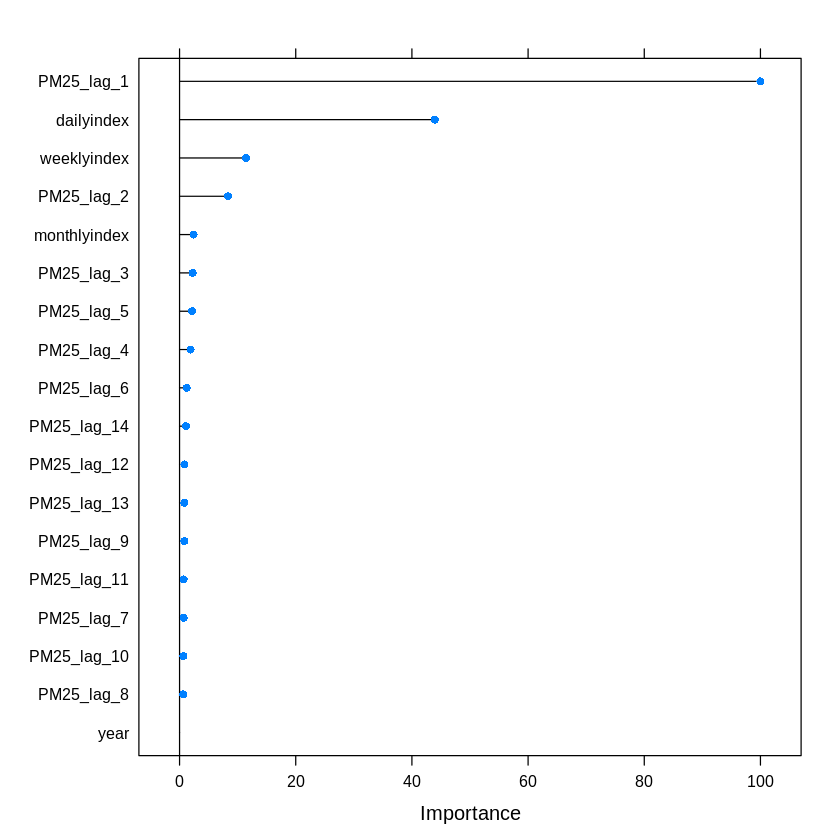

In [200]:
plot(varImp(rf1_cv))

In [44]:
pred_lm <- predict(lm1_cv, data_test_lagged)
R2(data_test_lagged$PM25,pred_lm)
MAE(data_test_lagged$PM25,pred_lm)
RMSE(data_test_lagged$PM25,pred_lm)


[1] 0.7821488

[1] 29.41522

[1] 44.69816

In [185]:
#pred_lm <- predict(lm1_cv, data_train_lagged)
#R2(data_train_lagged$PM25,pred_lm)
#MAE(data_train_lagged$PM25,pred_lm)
#RMSE(data_train_lagged$PM25,pred_lm)

[1] 0.7989293

[1] 34.16693

[1] 49.03341

In [186]:
#pred_lm <- predict(rf1_cv, data_train_lagged)
#R2(data_train_lagged$PM25,pred_lm)
#MAE(data_train_lagged$PM25,pred_lm)
#RMSE(data_train_lagged$PM25,pred_lm)

[1] 0.9676585

[1] 13.08483

[1] 20.55589

In [189]:
Result_output <- data.frame(date=data_test_lagged$dates,Observed=data_test_lagged$PM25,Predicted=pred_lm)


In [199]:
jpeg("Images/Daily_Testing_RF.jpeg", units="cm", width=20, height=15,res = 300)
ggplot(Result_output,aes(x=date))+geom_line(aes(y=Observed,color="Observed"))+geom_line(aes(y=Predicted,color="Predicted"))+
labs(x="Date",y="PM 2.5 (ug/m3)",color="")+theme_bw()
dev.off()

png 
  2

In [45]:
save.image(file = "Model_output/Forecasting_Index_Daily.RData") 